<a href="https://colab.research.google.com/github/atul1234anand/fastai/blob/master/6way.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

# Fetching the data

We start of by fetching the dataset, LIAR-PLUS from the github below. This comprises of a train, test and validation set.

In [4]:
! git clone https://github.com/Tariq60/LIAR-PLUS.git

Cloning into 'LIAR-PLUS'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 77 (delta 2), reused 0 (delta 0), pack-reused 68
Unpacking objects: 100% (77/77), done.


In [5]:
!ls


LIAR-PLUS  sample_data


In [6]:
path = Path('/content/LIAR-PLUS/dataset')
path.ls()

[PosixPath('/content/LIAR-PLUS/dataset/val2.tsv'),
 PosixPath('/content/LIAR-PLUS/dataset/train2.tsv'),
 PosixPath('/content/LIAR-PLUS/dataset/test2.tsv')]

Please uncomment one at a time and run the next 3 blocks of code.

In [0]:
data_F1 = pd.read_csv('/content/LIAR-PLUS/dataset/train2.tsv',delimiter='\t',encoding='utf-8', error_bad_lines=False,usecols=[2,3],names=['label','text'])
data_F1 = pd.read_csv('/content/LIAR-PLUS/dataset/test2.tsv',delimiter='\t',encoding='utf-8', error_bad_lines=False,usecols=[2,3],names=['label','text'])
data_F3 = pd.read_csv('/content/LIAR-PLUS/dataset/val2.tsv',delimiter='\t',encoding='utf-8', error_bad_lines=False,usecols=[2,3],names=['label','text'])

We create 3 folders in the csv format for ease of work(train.csv, test.csv and val.csv)

In [0]:
data_F1.to_csv('/content/LIAR-PLUS/dataset/train.csv') 
data_F2.to_csv('/content/LIAR-PLUS/dataset/test.csv') 
data_F3.to_csv('/content/LIAR-PLUS/dataset/val.csv') 

# Building the classifier

We begin our problem of classifying the given dataset into the 6 mentioned categories. Here Im using the [ULMfit](https://arxiv.org/abs/1801.06146) algorithm.

The ULMFit algorithm is as follows:


1.   Create (or, preferred, download a pre-trained) language model trained on a large corpus.
2.   Fine-tune this language model using your target corpus.
3.   Saving and using the encoder by passing it into a classifier.







**Step1: Building the language model**

We build our language model on the AWD_LTSM architecture which uses the WikiText-2 corpus.
This starts with building that Langauage Model databunch. We compute the learning rate graphically, fit the data and save the encoder.

In [0]:
data_lm = TextLMDataBunch.from_csv(path, 'train.csv')

In [0]:
data_lm.save('data_lm.pkl')

In [0]:
bs = 10
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


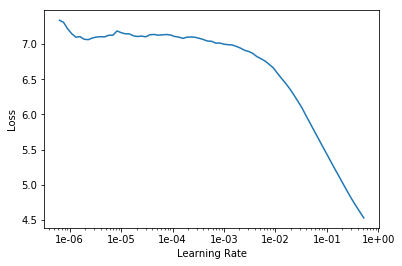

In [21]:
learn.recorder.plot(skip_end=15)

In [22]:
learn.fit_one_cycle(1, slice(1e-3,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.135097,1.079380,0.615857,00:08


In [0]:
learn.unfreeze()

In [24]:
learn.fit_one_cycle(8, slice(1e-3,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.703689,0.550950,0.757000,00:09
1,0.604636,0.543198,0.749143,00:09
2,0.595280,0.542473,0.751286,00:09
3,0.570393,0.543626,0.751857,00:09
4,0.560916,0.540232,0.760571,00:09
5,0.550767,0.538438,0.753571,00:09
6,0.546967,0.538500,0.760143,00:09
7,0.543512,0.537967,0.750714,00:09


In [0]:
learn.save_encoder('fine_tuned_enc')


**Step2:Pairing the classifier with the language model**

For building the classifier, we crearte a  data bunch and the language model's encoder. We then graphically analyse the learning rate  and train the model. Here we use the test.csv and val.csv files previously created to test the model.  

In [0]:
data_class = TextDataBunch.from_csv(path, 'train.csv',vocab = data_lm.vocab,test = 'test.csv',text_cols = 'text',label_cols = 'label')

In [27]:
data_class.show_batch()

text,target
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk - xxunk xxunk xxunk - xxunk xxunk xxmaj xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk,mostly-true
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk - xxunk xxunk xxunk - xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxup xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk true xxunk xxmaj xxunk xxmaj xxunk - xxunk xxmaj,false
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk - xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxup xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxmaj xxunk,false
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk mostly xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk - xxunk xxunk xxunk xxunk xxunk xxup xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,mostly-true
xxbos xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk,half-true


In [0]:
data_class.save('data_class.pkl')

In [0]:
data_clas = load_data(path, 'data_class.pkl', bs=bs)

In [0]:
learner = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learner.load_encoder('fine_tuned_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


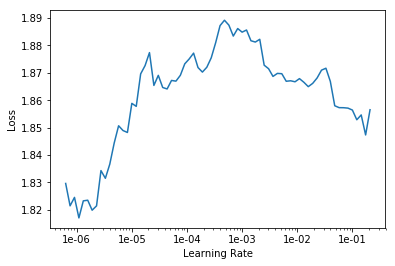

In [31]:
learner.lr_find()
learner.recorder.plot(skip_end=15)

In [32]:
learner.fit_one_cycle(2, slice(2e-3,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.774724,1.753866,0.219131,00:46
1,1.766585,1.750036,0.201074,00:45


In [0]:
learner.save('first')
learner.load('first')

In [34]:
learner.freeze_to(-2)
learner.fit_one_cycle(1, slice(2e-3,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.769059,1.751612,0.202538,00:54


In [0]:
learner.save('second')
learner.load('second')

In [36]:
learner.freeze_to(-3)
learner.fit_one_cycle(1, slice(1e-2,2e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.769156,1.754375,0.200586,01:13


In [37]:
learner.unfreeze()
learner.fit_one_cycle(5, slice(1e-2,2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.749987,1.752515,0.200098,01:43
1,1.757243,1.752706,0.200098,01:39
2,1.747479,1.752355,0.204002,01:37
3,1.749981,1.752103,0.200098,01:38
4,1.755450,1.752007,0.200098,01:41


In [0]:
data_val = TextDataBunch.from_csv(path, 'train.csv',vocab = data_lm.vocab,test = 'val.csv',text_cols = 'text',label_cols = 'label')

In [39]:
data_val.show_batch()

text,target
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk - xxunk xxunk xxunk - xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxup xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk true xxunk xxmaj xxunk xxmaj xxunk - xxunk xxmaj,false
xxbos xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk,mostly-true
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,true
xxbos xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk,false
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,true


In [0]:
data_val.save('data_val.pkl')
data_val = load_data(path, 'data_val.pkl', bs=bs)

In [0]:
learner1 = text_classifier_learner(data_val, AWD_LSTM, drop_mult=0.5)
learner1.load_encoder('fine_tuned_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


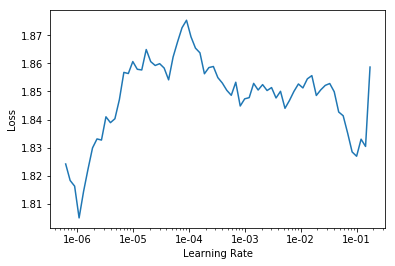

In [42]:
learner1.lr_find()
learner1.recorder.plot(skip_end=15)

In [44]:
learner1.fit_one_cycle(2, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.753355,1.754127,0.218643,00:45
1,1.769495,1.754250,0.214739,00:43


In [45]:
learner1.save('first')
learner1.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8191 items)
x: TextList
xxbos xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk,xxbos xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk
y: CategoryList
half-true,half-true,barely-true,false,half-true
Path: /content/LIAR-PLUS/dataset;

Valid: LabelList (2049 items)
x: TextList
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk - xxunk xxunk xxunk xxunk xxunk xxunk

In [51]:
learner1.freeze_to(-2)
learner1.fit_one_cycle(2, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.773171,1.754005,0.201562,00:53
1,1.747805,1.756075,0.192777,00:52


In [52]:
learner1.save('second')
learner1.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8191 items)
x: TextList
xxbos xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk,xxbos xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk
y: CategoryList
half-true,half-true,barely-true,false,half-true
Path: /content/LIAR-PLUS/dataset;

Valid: LabelList (2049 items)
x: TextList
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk - xxunk xxunk xxunk xxunk xxunk xxunk

In [53]:
learner1.freeze_to(-3)
learner1.fit_one_cycle(2, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.757539,1.754488,0.199610,01:18
1,1.750700,1.753403,0.199122,01:19


In [55]:
learner1.unfreeze()
learner1.fit_one_cycle(5, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.758181,1.755112,0.211323,01:40
1,1.755238,1.750923,0.196193,01:32
2,1.757627,1.752989,0.205466,01:33
3,1.746158,1.747559,0.207906,01:37
4,1.737905,1.748518,0.211811,01:42
